# Section 2 – Supervised learning – classification

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier


## 2.1 Train Test split

In [2]:
df = pd.read_parquet("df_tfidf.parquet") # words vectorized, converted tokens to numerical form

In [8]:
X = df.drop(columns=["Set_Fingerprint"])
y = df["Set_Fingerprint"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
print(y_train)
X_train

4699             [Defense Evasion, Discovery]
113772    [Discovery, Execution, Persistence]
64201     [Discovery, Execution, Persistence]
221592               [Discovery, Persistence]
198673               [Discovery, Persistence]
                         ...                 
119879    [Discovery, Execution, Persistence]
103694               [Discovery, Persistence]
131932               [Discovery, Persistence]
146867               [Discovery, Persistence]
121958               [Discovery, Persistence]
Name: Set_Fingerprint, Length: 163124, dtype: object


,enable,system,sh,cat,proc,mounts,bin,busybox,cd,dev,...,top,sleep,tar,passwd,nc,mkdir,unix,mv,nohup,tsm
4699,0.000000,0.000000,0.656004,0.121018,0.52813,0.111565,0.064612,0.000000,0.132227,0.037247,...,0.000000,0.131995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130346,0.000000
113772,0.059508,0.030009,0.000000,0.000000,0.00000,0.165067,0.238994,0.052892,0.000000,0.110218,...,0.213424,0.000000,0.504393,0.029694,0.107259,0.089269,0.427494,0.356797,0.000000,0.059519
64201,0.059508,0.030009,0.000000,0.000000,0.00000,0.165067,0.238994,0.052892,0.000000,0.110218,...,0.213424,0.000000,0.504393,0.029694,0.107259,0.089269,0.427494,0.356797,0.000000,0.059519
221592,0.112156,0.056559,0.000000,0.000000,0.00000,0.207403,0.000000,0.000000,0.000000,0.207731,...,0.000000,0.000000,0.279600,0.055966,0.000000,0.168248,0.000000,0.392271,0.000000,0.056088
198673,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.000000,0.000000,0.252625,...,0.000000,0.000000,0.340026,0.068061,0.000000,0.204608,0.000000,0.477045,0.000000,0.068210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.059508,0.030009,0.000000,0.000000,0.00000,0.165067,0.238994,0.052892,0.000000,0.110218,...,0.213424,0.000000,0.504393,0.029694,0.107259,0.089269,0.427494,0.356797,0.000000,0.059519
103694,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.000000,0.000000,0.252625,...,0.000000,0.000000,0.340026,0.068061,0.000000,0.204608,0.000000,0.477045,0.000000,0.068210
131932,0.128896,0.065000,0.000000,0.000000,0.00000,0.238360,0.000000,0.000000,0.000000,0.238736,...,0.000000,0.000000,0.321332,0.064319,0.000000,0.193360,0.000000,0.450819,0.000000,0.064460
146867,0.136394,0.068782,0.000000,0.000000,0.00000,0.252226,0.000000,0.000000,0.000000,0.252625,...,0.000000,0.000000,0.340026,0.068061,0.000000,0.204608,0.000000,0.477045,0.000000,0.068210


Binarize the labels to obtain a 7 binary classification problem

In [36]:
# OneHotEncoder: Not suitable because it is typically used for categorical variables where each instance has a single category.
# MultiLabelBinarizer: Specifically designed for multi-label classification, where each instance can belong to multiple categories.
mlb = MultiLabelBinarizer()
mlb.fit(y_train)
y_train_bin = mlb.transform(y_train)
y_test_bin = mlb.transform(y_test)
label_names = list(mlb.classes_)
y_train_bin

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1]])

## 2.2 Choose at least 2 ML methods

In [72]:
def print_confusion_matrix(confusion_matrix, label_names, train):
    plt.figure(figsize=(16, 8))
    if train:
        print('\nTrain set Confusion Matrices:\n')
    else:
        print('\nTest set Confusion Matrices:\n')
    for i, label in enumerate(label_names):
        plt.subplot(3, 3, i + 1)
        confusion_single = confusion_matrix[i]
        plt.title(f"{label} Confusion Matrix")
        plt.imshow(confusion_single, cmap='Blues', interpolation='nearest')
        for (j, k), value in np.ndenumerate(confusion_single):
            plt.text(k, j, f'{value}', ha='center', va='center', color='black' if confusion_single[j, k] < confusion_single.max() / 2 else 'white')
        
        plt.colorbar()
        plt.xticks(np.arange(2), ['Negative', 'Positive'])
        plt.yticks(np.arange(2), ['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        
    plt.tight_layout()
    plt.show()

### 2.2.1 Logistic Regression

As such, LogisticRegression does not handle multiple targets. But this is not the case with all the model in Sklearn.
To make this work for LogisticRegression, you need a MultiOutputClassifier wrapper.
This strategy consists of fitting one classifier per target. This is a simple strategy for extending classifiers that do not natively support multi-target classification.

In [65]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train_bin)
y_train_pred_lr = clf.predict(X_train)
y_test_pred_lr = clf.predict(X_test)
y_test_pred_lr

array([[0, 1, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 1, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 0, 0, 1]])

Performance evaluation:

Training set
                 precision    recall  f1-score   support

Defense Evasion       0.98      0.97      0.98     13365
      Discovery       1.00      1.00      1.00    162486
      Execution       1.00      0.98      0.99     65210
       Harmless       0.99      0.09      0.17      1536
         Impact       1.00      0.00      0.00        25
          Other       1.00      0.00      0.00       224
    Persistence       1.00      1.00      1.00    147864

      micro avg       1.00      0.99      0.99    390710
      macro avg       1.00      0.58      0.59    390710
   weighted avg       1.00      0.99      0.99    390710
    samples avg       1.00      0.99      0.99    390710

Test set
                 precision    recall  f1-score   support

Defense Evasion       0.98      0.96      0.97      5634
      Discovery       1.00      1.00      1.00     69659
      Execution       1.00      0.98      0.99     27717
       Harmless       1.00      0.09      0.17       670
     

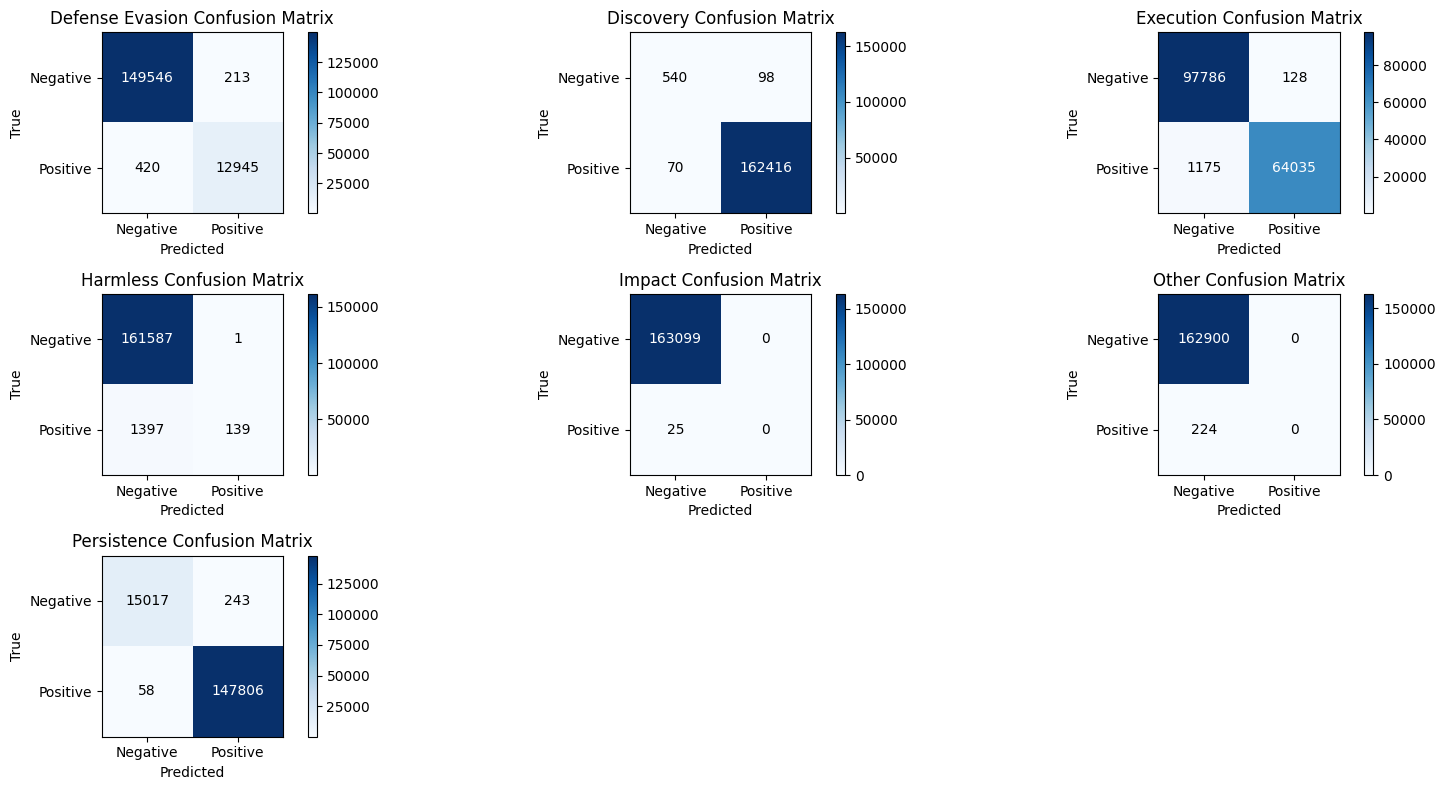


Test set Confusion Matrices:



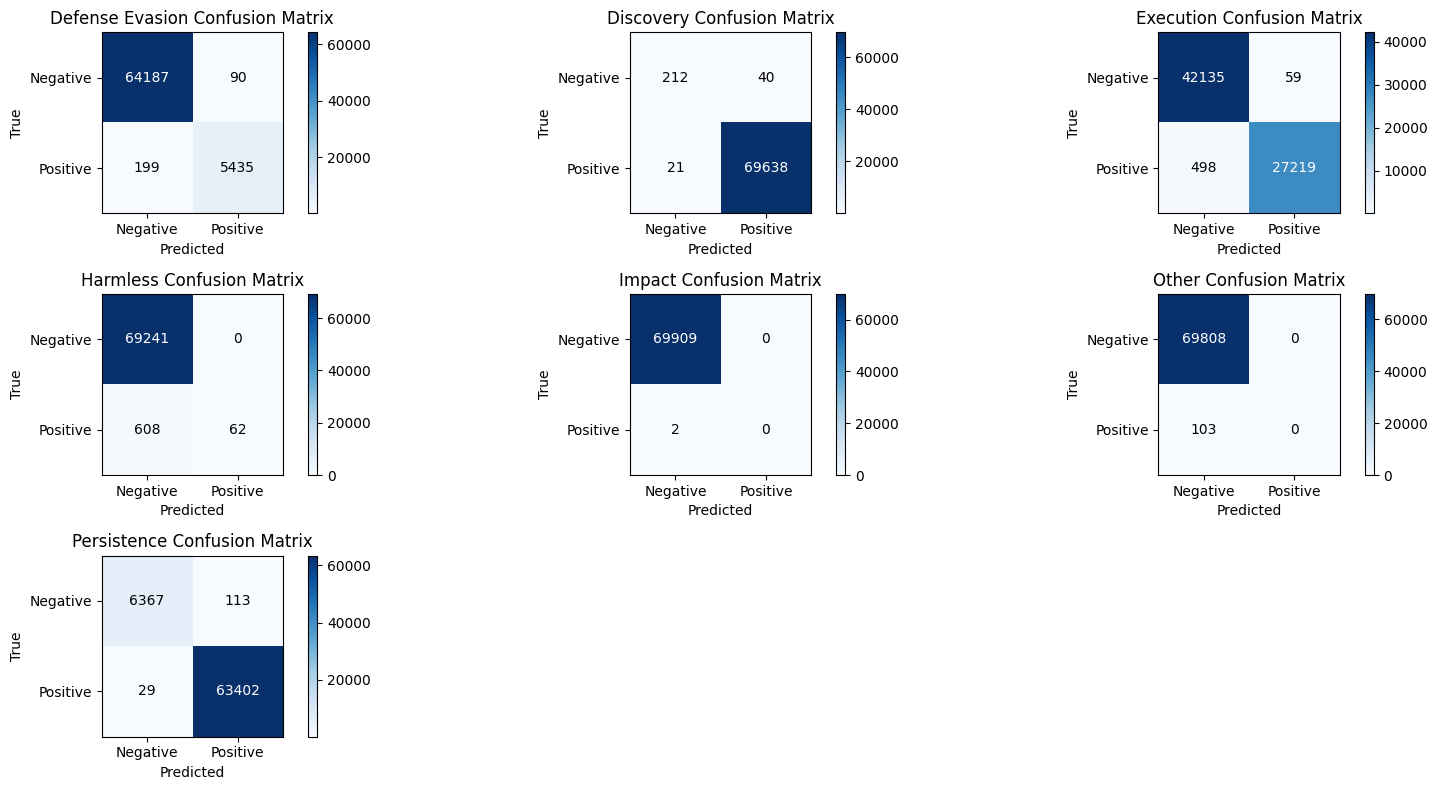

In [67]:
# classification report
print('Training set')
print(classification_report(y_train_bin, y_train_pred_lr, target_names=label_names, zero_division=1))
print('Test set')
print(classification_report(y_test_bin, y_test_pred_lr, target_names=label_names, zero_division=1))

# confusion matrices
confusion_train_lr = multilabel_confusion_matrix(y_train_bin, y_train_pred_lr)
print_confusion_matrix(confusion_train_lr, label_names, True)
confusion_test_lr = multilabel_confusion_matrix(y_test_bin, y_test_pred_lr)
print_confusion_matrix(confusion_test_lr, label_names, False)


### 2.2.2 K-Nearest Neighbors

In [64]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train_bin)
y_train_pred_knn = knn_clf.predict(X_train)
y_test_pred_knn = knn_clf.predict(X_test)

Training set
                 precision    recall  f1-score   support

Defense Evasion       0.99      0.97      0.98     13365
      Discovery       1.00      1.00      1.00    162486
      Execution       1.00      0.99      0.99     65210
       Harmless       0.90      0.18      0.30      1536
         Impact       0.92      0.44      0.59        25
          Other       1.00      0.97      0.99       224
    Persistence       1.00      1.00      1.00    147864

      micro avg       1.00      0.99      1.00    390710
      macro avg       0.97      0.79      0.84    390710
   weighted avg       1.00      0.99      1.00    390710
    samples avg       1.00      0.99      1.00    390710

Test set
                 precision    recall  f1-score   support

Defense Evasion       0.99      0.97      0.98      5634
      Discovery       1.00      1.00      1.00     69659
      Execution       1.00      0.99      0.99     27717
       Harmless       0.89      0.15      0.26       670
     

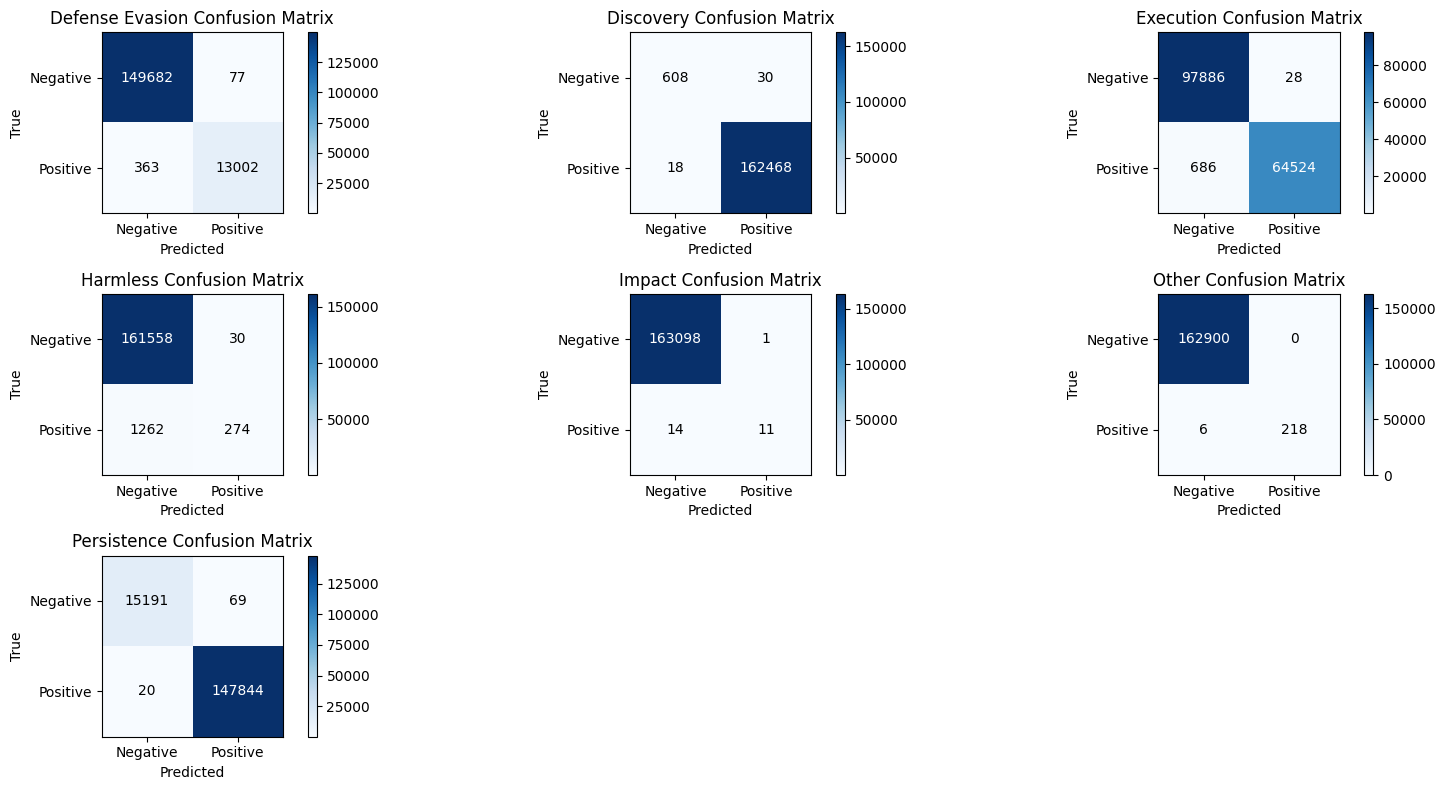


Test set Confusion Matrices:



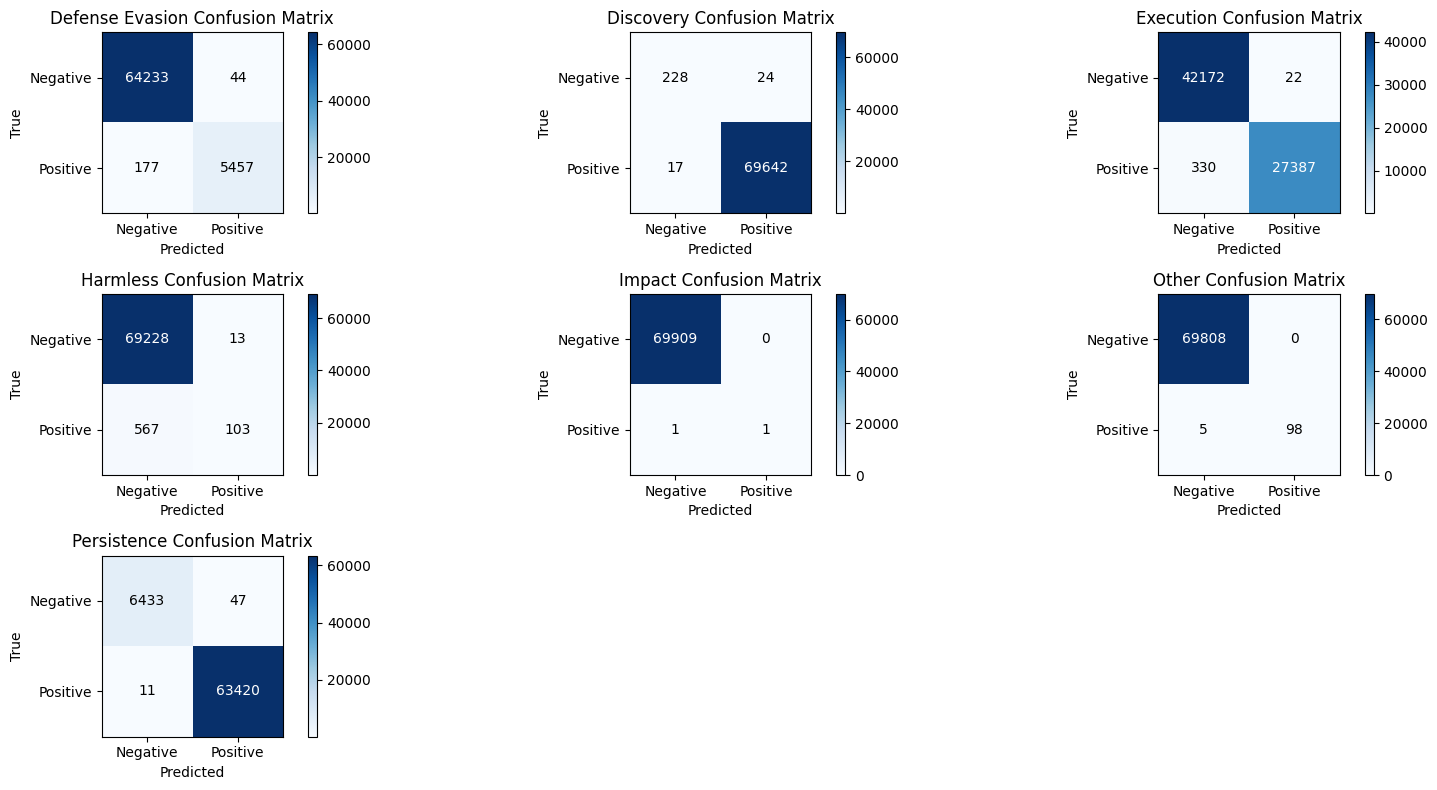

In [68]:
# classification report
print('Training set')
print(classification_report(y_train_bin, y_train_pred_knn, target_names=label_names, zero_division=1))
print('Test set')
print(classification_report(y_test_bin, y_test_pred_knn, target_names=label_names, zero_division=1))

# confusion matrices
confusion_train_knn = multilabel_confusion_matrix(y_train_bin, y_train_pred_knn)
print_confusion_matrix(confusion_train_knn, label_names, True)
confusion_test_knn = multilabel_confusion_matrix(y_test_bin, y_test_pred_knn)
print_confusion_matrix(confusion_test_knn, label_names, False)

### 2.2.3 Random Forest

In [70]:
rf_clf = RandomForestClassifier(n_estimators=30)
rf_clf.fit(X_train, y_train_bin)
y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

Training set
                 precision    recall  f1-score   support

Defense Evasion       1.00      0.97      0.98     13365
      Discovery       1.00      1.00      1.00    162486
      Execution       1.00      0.99      0.99     65210
       Harmless       0.92      0.19      0.31      1536
         Impact       0.96      0.92      0.94        25
          Other       1.00      0.99      1.00       224
    Persistence       1.00      1.00      1.00    147864

      micro avg       1.00      0.99      1.00    390710
      macro avg       0.98      0.87      0.89    390710
   weighted avg       1.00      0.99      1.00    390710
    samples avg       1.00      0.99      1.00    390710

Test set
                 precision    recall  f1-score   support

Defense Evasion       0.99      0.97      0.98      5634
      Discovery       1.00      1.00      1.00     69659
      Execution       1.00      0.99      0.99     27717
       Harmless       0.90      0.16      0.27       670
     

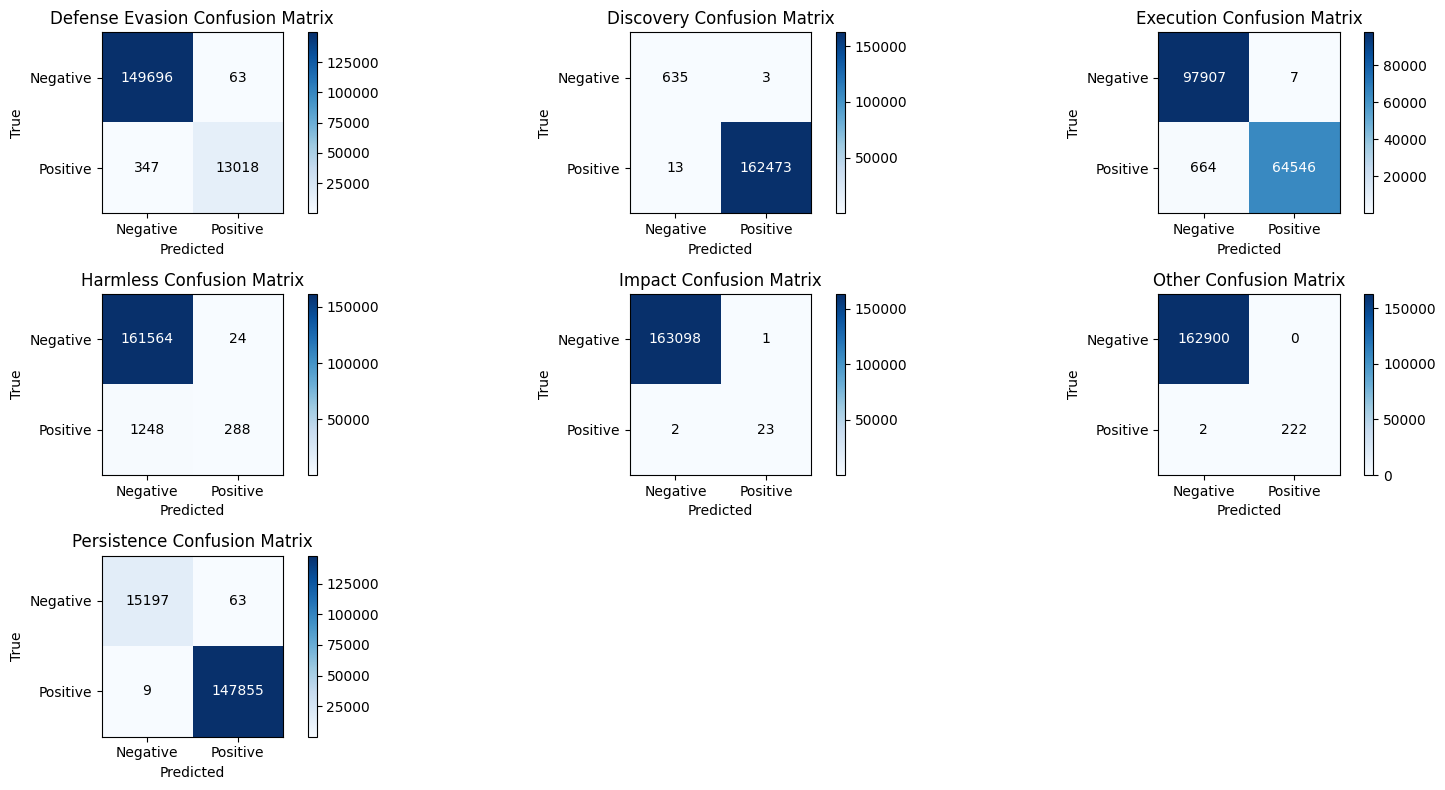


Test set Confusion Matrices:



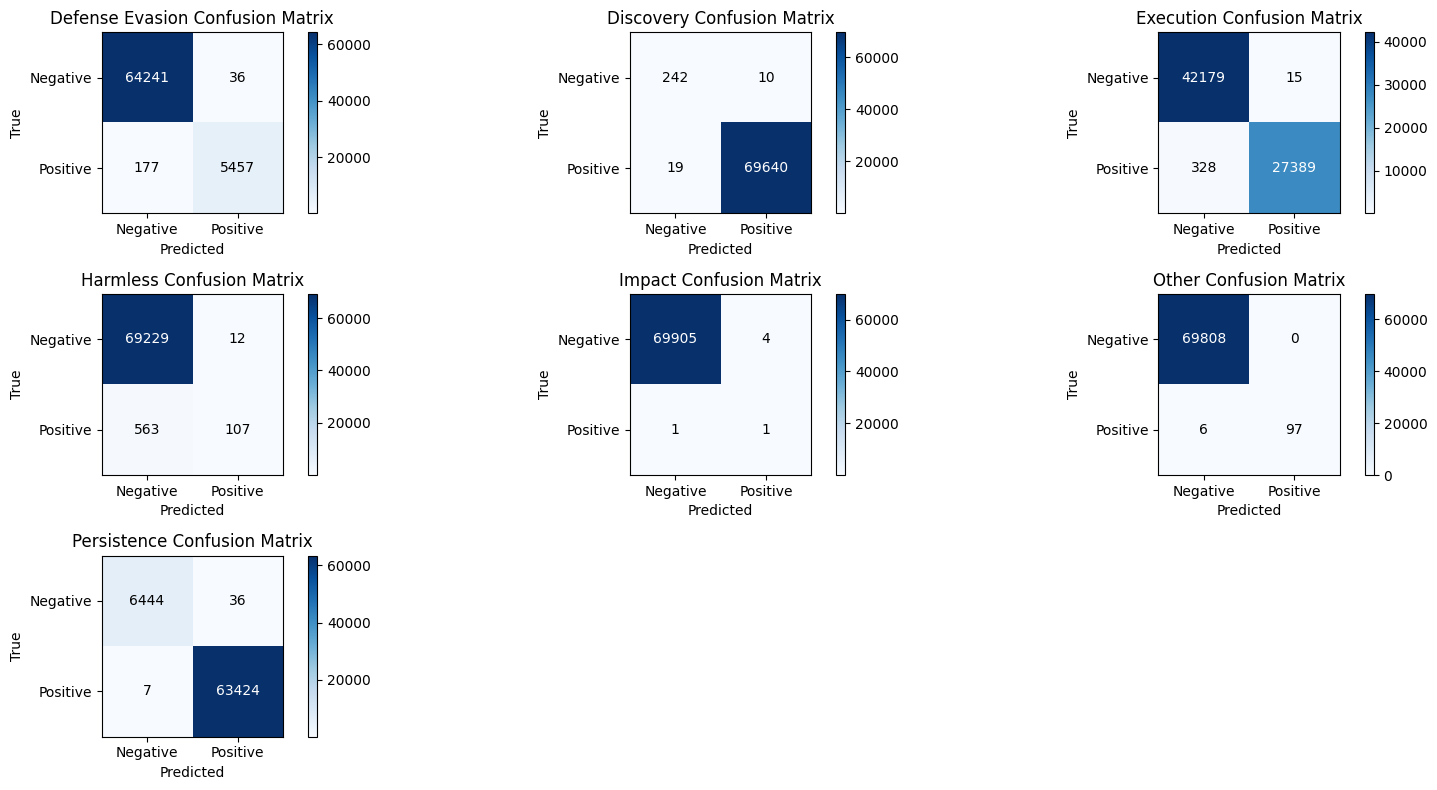

In [71]:
# classification report
print('Training set')
print(classification_report(y_train_bin, y_train_pred_rf, target_names=label_names, zero_division=1))
print('Test set')
print(classification_report(y_test_bin, y_test_pred_rf, target_names=label_names, zero_division=1))

# confusion matrices
confusion_train_rf = multilabel_confusion_matrix(y_train_bin, y_train_pred_rf)
print_confusion_matrix(confusion_train_rf, label_names, True)
confusion_test_rf = multilabel_confusion_matrix(y_test_bin, y_test_pred_rf)
print_confusion_matrix(confusion_test_rf, label_names, False)

## 2.3 Tune Hyperparameters